# Semana 7 do Aceleradev DS Codenation

### Professor: Kazuki Yokoyama | Tema: Feature Engineering

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## O que é Feature Engineering?

Todo modelo de aprendizado de máquinas é alimentado com dados, que precisam ser trabalhados para que o modelo aprenda adequadamente e retorne boas predições. Isso é *engenharia de features*! muitas vezes os dados estão fora de escala, ou um dado categórico, se transformado em categoria numérica, pode enriquecer os dados de treino. Essa habilidade do DS é muito importante no processo, pois os dados não vêm *bonitinhos* prontos para serem consumidos, eles precisam ser *engenheirados* primeiro, e grande parte do tempo gasto na resolução de um problema com ML, é nessa etapa. Portanto, **Feature Engineering** é expor os dados de uma maneira que os algorítmos de ML possam tomar vantagem.

**Fixando uma seed**

In [136]:
np.random.seed(2000)

**Criação de DataFrame Aleatório com variáveis categóricas e numéricas**

In [137]:
linhas = 100

In [138]:
altura = np.random.normal(loc=1.7, scale=.2, size=linhas).round(3)
ponto = np.random.normal(loc=7, scale=1,size=linhas).round(3)
cursos = ['mat', 'fis', 'bio']
curso = np.random.choice(a=cursos, size=linhas)

In [139]:
df = pd.DataFrame({'altura': altura,
                  'ponto': ponto,
                  'curso': curso})
df.head()

,altura,ponto,curso
0,2.047,7.021,mat
1,2.080,7.598,bio
2,1.279,9.153,fis
3,1.670,7.321,bio
4,1.817,5.865,mat


`df` é uma tabela que contém três variáveis, duas **numéricas** e uma **categórica**

## Começando a Engenharia de Features

### Variáveis Categóricas

**One-hot Encoding:** As $n$ categorias da variável categórica serão usadas para criação de novas colunas na sua tabela. Cada categoria representará uma coluna. Como uma tupla consegue ter apenas uma categoria, a coluna correspondente à categoria terá o valor 1 (Hot) preenchido, enquanto as demais terão 0 (Cold) preenchido. Perceba que teremos novas variáveis **binarias** em nosso `df`

Para fazer isso, usaremos uma classe do sklearn.preprocessing, o **OneHotEncoder**

```python
sklearn.preprocessing.OneHotEncoder(sparse=False, dtype=np.uint8)
```

**Nota:** caso deixe `sparse=True`, vc terá uma matriz `sparse matrix`. Ela economiza mais memória, mas não mostra a matriz diretamente. Para revelar então

```python
sparse_matrix.toarray()
```

In [140]:
from sklearn.preprocessing import OneHotEncoder

In [141]:
one_hot_enc = OneHotEncoder(sparse=False, dtype=np.uint8)

In [142]:
course_enc = one_hot_enc.fit_transform(df[['curso']])  # lembre de colocar [[]] pro atributo entender que é um (n x 1)

In [143]:
course_enc.shape

(100, 3)

In [144]:
course_enc[:5]

array([[0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1]], dtype=uint8)

In [145]:
one_hot_enc.categories_

[array(['bio', 'fis', 'mat'], dtype=object)]

In [146]:
cat_columns = one_hot_enc.categories_[0]

Podemos concatenar essas informações ao `df`

In [147]:
df_dois = df.join(pd.DataFrame(course_enc, columns=cat_columns))
df_dois.head()

,altura,ponto,curso,bio,fis,mat
0,2.047,7.021,mat,0,0,1
1,2.080,7.598,bio,1,0,0
2,1.279,9.153,fis,0,1,0
3,1.670,7.321,bio,1,0,0
4,1.817,5.865,mat,0,0,1


**Binarização:** Processo que discretiza uma variável numérica contínua, tendo um certo *limite* como parâmetro. O valor **acima do limite** recebe 1, já **abaixo do limite** recebe 0

Para fazer isso, usaremos uma classe do sklearn.preprocessing, o **Binarizer**
```python
sklearn.preprocessing.Binarizer(threshold=float)
```

In [148]:
from sklearn.preprocessing import Binarizer

O limite para `altura` será de 1.8

In [149]:
binarizer = Binarizer(threshold=1.8)

In [150]:
binary = binarizer.fit_transform(df[['altura']])

In [151]:
binary.flatten()

array([1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.])

In [152]:
df_tres = df_dois.join(pd.Series(binary.flatten(), name='alto'))
df_tres.head()

,altura,ponto,curso,bio,fis,mat,alto
0,2.047,7.021,mat,0,0,1,1.0
1,2.080,7.598,bio,1,0,0,1.0
2,1.279,9.153,fis,0,1,0,0.0
3,1.670,7.321,bio,1,0,0,0.0
4,1.817,5.865,mat,0,0,1,1.0


**Intervalo de Classes (Binnig):** Também conhecido como discretização, seu papel é categorizar variáveis numéricas contínuas, sendo a categoria um intervalo que contém a informação

$$2.456 \subset 2\vdash3$$

Com **sklearn**:
```python
sklearn.preprocessing.KBinsDiscretizer(n_bins=int, encode=, strategy=)
```
*Parâmetros:*

- encode: {'onehot', 'ordinal'}
    - 'onehot': resulta uma `sparse matrix` de *one-hot encoding*
    - 'ordinal': resulta inteiros que correspondem à qual intervalo de classe o valor pertence
- strategy: {'uniform', 'quantile'}
    - uniform: faz intervalos de classe de tamanhos iguais
    - quantile: faz intervalos de modo a terem a mesma frequência

**Atributos:**

- KBinsDiscretizer().bin_edges_: retorna um array com os limites dos intervalos de classes

Com **pandas**
```python
pd.cut(x=1-d array, bins=, labels=None)
```
*Parâmetros:*

- bins: int ou list
    - int: gera *int* intervalos de classes
    - list: usa os valores de *list* para fazer os intervalos
- labels: list ou None
    - list: podem ser uma lista de *strings*. Para bins=3, labels=['ruim', 'medio', 'bom']

In [153]:
from sklearn.preprocessing import KBinsDiscretizer

In [154]:
binning = KBinsDiscretizer(n_bins=4, encode='onehot', strategy='uniform')

In [155]:
one_hot_binning = binning.fit_transform(df[['ponto']]).toarray()  # colunas onehot

In [156]:
limites_intervalos = binning.bin_edges_
limites_intervalos[0]

array([4.696  , 5.81025, 6.9245 , 8.03875, 9.153  ])

In [157]:
intervalos = pd.cut(df_tres['ponto'], bins=4)
intervalos.unique()

[(6.924, 8.039], (8.039, 9.153], (5.81, 6.924], (4.692, 5.81]]
Categories (4, interval[float64]): [(4.692, 5.81] < (5.81, 6.924] < (6.924, 8.039] < (8.039, 9.153]]

**Nota:** use os intervalos do **cut**, mesmo sendo possível passar os advindos do **KBinsDiscretizer()**. Devido à arredondamentos diferentes, pode ser que apareçam valores com NaN. Portanto, na função **pd.cut()**, use a **mesma quantidade de bins** passada em **KBinsDiscretizer()**

In [158]:
df_onehot = pd.DataFrame(one_hot_binning, columns=intervalos.unique())
df_quatro = df_tres.join(df_onehot)
df_quatro.head()

,altura,ponto,curso,bio,fis,mat,alto,"(6.924, 8.039]","(8.039, 9.153]","(5.81, 6.924]","(4.692, 5.81]"
0,2.047,7.021,mat,0,0,1,1.0,0.0,0.0,1.0,0.0
1,2.080,7.598,bio,1,0,0,1.0,0.0,0.0,1.0,0.0
2,1.279,9.153,fis,0,1,0,0.0,0.0,0.0,0.0,1.0
3,1.670,7.321,bio,1,0,0,0.0,0.0,0.0,1.0,0.0
4,1.817,5.865,mat,0,0,1,1.0,0.0,1.0,0.0,0.0


Seria interessante usar o atributo *labels* de pd.cut(). Como são notas, poderiam ser ['ruim', 'medio', 'bom', 'excelente']

Embora tenhamos lidado tanto com variáveis já categóricas quanto numéricas, a idéia era torná-las **categóricas** de uma maneira que um modelo entenda. E fizemos com o **one-hot encoding** e **binarização**, dando a possibilidade de **binarizar** esses tipos de variáveis

### Variáveis Numéricas

As transformações mais comuns de variáveis numéricas são: **Normalização** e **Padronização**. A primeira gera uma feature numérica que respeita uma determinada escala, geralmente é $[0,1]$ ou $[-1,1]$. Já a segunda, gera uma feature numérica de $\overline{x}=0$ e $s=1$. A idéia é ter variáveis que possuam a mesma ordem de grandeza.

Sempre que vamos treinar um modelo de regressão, usamos muitas features, e ter elas em escalas tão diferentes impacta o apredizado. Enquanto uma feature está contida em $[0,100]$, outra pode estar em $[0, 1000]$. Isso confere uma importancia maior à esta de ordem de grandeza maior, mas nem sempre essa *impotância* existe. Imagine que seja `Idade` $\subset [0,100]$ e `Salário` $\subset [0,1000]$. Não existe grau de importancia, são dados de natureza totalmente diferente, e a escala entre eles não reflete que um é mais importante que o outro. Diante disso, ter os dados **numa mesma escala** elimina esse problema, e as diferenças dos intervalos dos valores é respeitada. No caso de Regressões Logísticas, ou RandomForest, a normalização não se faz muuuito importante, pois os cálculos usados não dependem muito de distâncias Euclidianas

**Nota:** Quando uma variáveis **não possui distribuição normal**, a **padronização** não é um bom escalímetro

**Normalização:** Como nesse [notebook](https://github.com/mikaelcordeiro/semanas/blob/semana_7/semana7/semana_7.ipynb) já tem explicação, vamos só praticar

In [159]:
from sklearn.preprocessing import MinMaxScaler

Como `altura` varia está quase contida $[1, 2]$, podemos normalizar `ponto` nessa escala

In [160]:
norm = MinMaxScaler(feature_range=(1, 2))

In [161]:
normalizados = norm.fit_transform(df[['ponto']]).flatten()

In [162]:
df_cinco = df_quatro.join(pd.Series(normalizados, name='ponto_1_2_norm'))

In [246]:
df_cinco.head()

,altura,ponto,curso,bio,fis,mat,alto,"(6.924, 8.039]","(8.039, 9.153]","(5.81, 6.924]","(4.692, 5.81]",ponto_1_2_norm
0,2.047,7.021,mat,0,0,1,1.0,0.0,0.0,1.0,0.0,1.521651
1,2.080,7.598,bio,1,0,0,1.0,0.0,0.0,1.0,0.0,1.651111
2,1.279,9.153,fis,0,1,0,0.0,0.0,0.0,0.0,1.0,2.000000
3,1.670,7.321,bio,1,0,0,0.0,0.0,0.0,1.0,0.0,1.588961
4,1.817,5.865,mat,0,0,1,1.0,0.0,1.0,0.0,0.0,1.262284


Podemos comparar a diferença das distribuições *antes* e *depois* da normalização. Fica claro como os dados não possuem a mesma escala

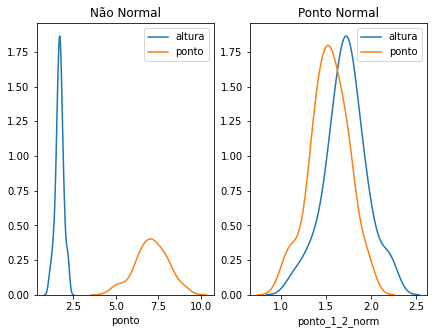

In [259]:
figure, g = plt.subplots(1, 2, figsize=(7, 5))
sns.distplot(df_cinco['altura'], hist=False, ax=g[0], label='altura')
sns.distplot(df_cinco['ponto'], hist=False, ax=g[0], label='ponto')
sns.distplot(df_cinco['altura'], hist=False, ax=g[1], label='altura')
sns.distplot(df_cinco['ponto_1_2_norm'], hist=False, ax=g[1], label='ponto')
g[0].set_title('Não Normal')
g[0].legend(loc='best')
g[1].set_title('Ponto Normal')
plt.show()

**Padronização:** também já descrito nesse [notebook](https://github.com/mikaelcordeiro/semanas/blob/semana_7/semana7/semana_7.ipynb), vamos praticar

In [164]:
from sklearn.preprocessing import StandardScaler

In [165]:
padronizador = StandardScaler()

In [166]:
padronizado = padronizador.fit_transform(df_cinco[['ponto']]).flatten()

In [256]:
df_seis = df_cinco.join(pd.Series(padronizado, name='ponto_padronizado'))
df_seis.head()

,altura,ponto,curso,bio,fis,mat,alto,"(6.924, 8.039]","(8.039, 9.153]","(5.81, 6.924]","(4.692, 5.81]",ponto_1_2_norm,ponto_padronizado
0,2.047,7.021,mat,0,0,1,1.0,0.0,0.0,1.0,0.0,1.521651,-0.064542
1,2.080,7.598,bio,1,0,0,1.0,0.0,0.0,1.0,0.0,1.651111,0.544365
2,1.279,9.153,fis,0,1,0,0.0,0.0,0.0,0.0,1.0,2.000000,2.185354
3,1.670,7.321,bio,1,0,0,0.0,0.0,0.0,1.0,0.0,1.588961,0.252047
4,1.817,5.865,mat,0,0,1,1.0,0.0,1.0,0.0,0.0,1.262284,-1.284467


Vamos olhar o comparativo dos dados **padronizados**

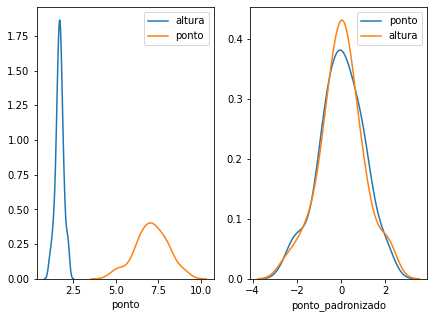

In [258]:
figure, g = plt.subplots(1, 2, figsize=(7, 5))
sns.distplot(df_seis['altura'], hist=False, ax=g[0], label='altura')
sns.distplot(df_seis['ponto'], hist=False, ax=g[0], label='ponto')
sns.distplot(df_seis['ponto_padronizado'], hist=False, ax=g[1], label='ponto')
sns.distplot(padronizador.fit_transform(df_seis[['altura']]).flatten(), hist=False, ax=g[1], label='altura')
plt.show()

**Valores Faltantes:** ao longo do curso, usamos o pd.Series.fillna() para lidar com os *missing values*. Podemos usar também, a classe SimpleImputer

Classe **SimpleImputer**

```python
sklearn.impute.SimpleImputer(missing_values=, strategy=, fill_value=)
```
*Parâmetros:*

- missing_values: preencher com o que significa *dado faltante*
    - np.nan: os nan serão identificados como missing
    - string: a *string* será encarada como missing
- strategy: ('mean', 'median', 'most_frequent', 'constant')
    - mean: preenche com a média
    - median: preenche com a mediana
    - most_frequent: preenche com a moda
    - constant: preenche com o que está no parâmetro **fill_value**
- fill_value: string ou valor numérico que preencherá o identificado como missing

In [168]:
a = pd.DataFrame(np.array([[1, 2, 'unknown'], [4, np.nan, 'casa'], [np.nan, 8, 'carro']]), columns=['a', 'b', 'c'])
a

,a,b,c
0,1,2,unknown
1,4,nan,casa
2,nan,8,carro


In [169]:
from sklearn.impute import SimpleImputer

In [170]:
fill = SimpleImputer(missing_values='unknown', strategy='constant', fill_value='nao sei')

In [171]:
d = fill.fit_transform(a[['c']])
d

array([['nao sei'],
       ['casa'],
       ['carro']], dtype=object)

In [172]:
fill = SimpleImputer(missing_values=np.nan, strategy='mean')

In [173]:
e = fill.fit_transform(a[['a', 'b']])
e

array([[1. , 2. ],
       [4. , 5. ],
       [2.5, 8. ]])

### Pipeline

O **sklearn** disponibiliza uma classe chamada **Pipeline**. Nela, podemos dizer quais transformações queremos nos nossos dados. Para um *dataframe* pequeno, dá pra ir fazendo na mão, como acima,  mas para os grandes, é uma mão na roda. E tal qual treinamos um modelo, essa classe pode ser treinada e reutilizada depois.

vamos pegar o `df`

In [174]:
df_copia = df.copy()
df_copia.head()

,altura,ponto,curso
0,2.047,7.021,mat
1,2.080,7.598,bio
2,1.279,9.153,fis
3,1.670,7.321,bio
4,1.817,5.865,mat


Como o **Pipeline** tem métodos que lidam com *missing values*, vamos colocar alguns nesse `df`. Para variáveis numéricas, os valores serão preenchidos com `np.nan`, e para as categóricas, com `Unknown`

In [175]:
nan_altura_index = np.random.choice(df_copia.index, size=10, replace=False)
nan_ponto_index = np.random.choice(df_copia.index, size=10, replace=False)
nan_curso_index = np.random.choice(df_copia.index, size=10, replace=False)

In [176]:
df_copia.loc[nan_altura_index, 'altura'] = np.nan
df_copia.loc[nan_ponto_index, 'ponto'] = np.nan
df_copia.loc[nan_curso_index, 'curso'] = 'unknown'

In [177]:
df_copia.head()

,altura,ponto,curso
0,2.047,7.021,mat
1,2.080,7.598,bio
2,1.279,9.153,fis
3,1.670,NaN,bio
4,1.817,5.865,mat


Classe **Pipeline**

```python
sklearn.preprocessing.Pipeline(steps=[('processo', class), ('processo', class), ..., ('processo', class)])
```
*Parâmetros:*

- steps: lista de tuplas. Cada classe é uma engenharia no dado
    - ('normaliza', MinMaxScalar())
    - ('padroniza', StandardScaler())
    - ('fillna', SimpleImputer(strategy='mean'))
    entre outros

**Nota:** o pipeline fará os steps para todas as variáveis dentro do fit_transform. Portanto, perceba se não vc não está misturando variáveis categóricas com numéricas

In [178]:
from sklearn.pipeline import Pipeline

In [179]:
pipeline_numericas = Pipeline(steps=[
    ('missing', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('norm_0_1', MinMaxScaler(feature_range=(0, 1)))
])

In [180]:
piped = pipeline_numericas.fit_transform(df_copia[['altura', 'ponto']])

In [181]:
x, y = zip(*pipeline_numericas.steps)
x[1:]

('norm_0_1',)

In [182]:
pipeline_categoricas = Pipeline(steps=[
    ('missing', SimpleImputer(missing_values='unknown', strategy='constant', fill_value='bio')),
    ('onehot', OneHotEncoder(sparse=False, dtype=np.uint8))
])

In [183]:
piped_categ = pipeline_categoricas.fit_transform(df_copia[['curso']])

In [184]:
pipeline_categoricas.get_params()['onehot'].categories_[0]

array(['bio', 'fis', 'mat'], dtype=object)

Agora é só juntar as variáveis para criar um novo `df` *engenheirado*

### Outliers

*Por que temos que olhar para eles?*

![outlier](https://www.stats4stem.org/common/web/plugins/ckeditor/plugins/doksoft_uploader/userfiles/WithInfOutlier.png)

Na imagem acima, percebe-se que os quatro primeiros pontos do *eixo x* parecem seguir uma tendência, e o quinto ponto não segue a mesma dinâmica. Um modelo de regressão linear tenta encontrar uma reta que minimize o resíduo e maximize a variância (PCA). A técnica dos *Mínimos Quadrados* é feita em cima dos resíduos. Perceba que, na tentativa de gerar um melhor *fit*, a tendência demonstrada nos quatro primeiros pontos é alterada devido ao quinto, claramente deslocado. Isso é o que um *outlier* faz num modelo de regressão, ele exerce muita influência no modelo. E não só numa regressão linear, medidas estatísticas como média e variância são impactadas também.

*Como eles ocorrem?*

Quem faz experimentos, não necessariamente das exatas, já se deparou com valores muito estranhos neles. Pode ser erro de calibragem, pode ser um fenômeno não previsto na teoria, pode ser um evento possível mas muito raro. Essas situações nos dizem o que fazer com esses *pontos fora da curva* 

Vamos analisar a coluna `altura` e investigar se exitem *outliers*

In [204]:
altura_copia = df_seis['altura']

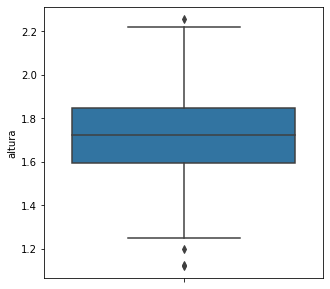

In [222]:
plt.figure(figsize=(5,5))
sns.boxplot(altura_copia, orient='v')
plt.show()

Com um **boxplot**, podemos identificar a existência de *outliers*

Já foi explorada a fórmula dos quartis, mas não custa nada relembrar

$$\text{Amplitude Inter Quartil}: IQR=Q_3-Q_1$$
$$\text{Limite Inferior}: L_i=Q_1-1.5\times IQR$$
$$\text{Limite Superior}: L_s=Q_3+1.5\times IQR$$

Ou seja, é considerado um *outlier* todo dado que estiver fora do intervalo estipulado pelos limites inferior e superior

$$\text{Outlier} \not\subset [L_i, L_s]$$

In [227]:
def encontra_outliers(lista: pd.Series):
    iqr = lista.quantile(.75) - lista.quantile(.25)
    li = lista.quantile(.25) - 1.5*iqr
    lf = lista.quantile(.75) + 1.5*iqr
    outliers = pd.Series(lista[~lista.between(li, lf)], name='outliers')
    return outliers

In [228]:
encontra_outliers(df_seis['altura'])

21    1.196
35    1.120
49    1.125
78    2.256
Name: outliers, dtype: float64

Podemos procurar por eles com um **Histograma**, basta olhar a frequência nas *caudas* da distrubuição

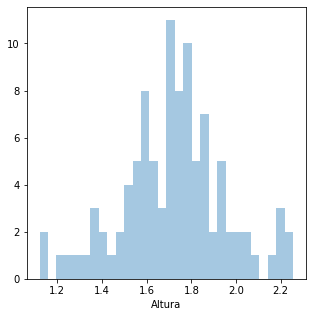

In [260]:
plt.figure(figsize=(5,5))
sns.distplot(df_seis['altura'],bins=30, kde=False, axlabel='Altura')
plt.show()

Como dito, olhando para as *caudas* da distribuição, podemos perceber quem são os *outliers*. Mas onde essa *cauda* começa? Tratando-se de uma distribuição de frequências, a média tende a ser a maior ocorrência, e à medida que nos distanciamos dela, falando em **desvio-padrão**, podemos entender onde essa cauda começa. Muitos encaram **três** desvios como uma distância sufuciente. Diante disso

$$\text{Outliers} \not\subset [-3\sigma+\overline{x},\overline{x}+3\sigma]$$

Uma maneira mais fácil de visualizar isso, é trabalhar com os dados **padronizados**. Como $\overline{x}=0$ e $\sigma=1$, os *outliers* encontram-se

$$\text{Outliers} \not\subset [-3, 3]$$

In [275]:
def outliers_std(lista: pd.Series, stdzed=False, fact=3):
    if stdzed:
        outliers = lista[~lista.between(-fact, fact)]
    else:
        med = lista.mean()
        std = lista.std()
        outliers = lista[~lista.between(-fact*std+med, med+fact*std)]
    return pd.Series(outliers, name='outliers')

In [280]:
outliers_std(pd.Series(padronizador.fit_transform(df_seis[['altura']]).flatten()), stdzed=True, fact=2.2)

21   -2.249791
35   -2.577705
49   -2.556132
78    2.323744
Name: outliers, dtype: float64

**Perceba:** Para encontrar os mesmos *outliers* que a maneira **boxplot**, o número de desvios que teve de ser adotado foi de 2.2

**Parte Crucial:** Manter ou retirar os dados? Esses dados representam alguma espécie de erro? Esses dados são de `altura`, não sabemos qual faixa etária, mas até no mundo real existem casos de pessoas muito pequenas ou muito altas. E esse establecimento, do que é alto ou baixo é uma medida não tão precisa. Esses são questionamentos que devem ser feitos para tomar a decisão de manter ou retirar os dados.

Uma abordagem interessante é substituir o *outlier* pelo **piso** ou **teto** dos valores da variável. Assim, vc preenche esse dados *anômalos* com o limite do aceitável. Diante disso, basta substituir por $L_i$ quando é um *outlier* muito pequeno, ou por $L_s$ quando é um muito grande. Isso é chamado de **CAP**